# Main Idea for Focused Crop

In [2]:
import numpy as np
from torchvision.transforms import functional as F
import random

class RandomizedFocusedCrop:
    def __init__(self, crop_size=320, max_shift=20):
        """
        Args:
            crop_size (int): Size of the crop.
            max_shift (int): Maximum number of pixels to randomly shift the crop center.
        """
        self.crop_size = crop_size
        self.max_shift = max_shift

    def __call__(self, image, mask):
        # Convert mask to numpy
        mask_np = np.array(mask)
        # Focus only on oil spill label (1)
        oil_spill_mask = (mask_np == 1).astype(np.uint8)

        # Find oil spill region in mask
        oil_spill_indices = np.argwhere(oil_spill_mask > 0)

        if len(oil_spill_indices) > 0:
            # Calculate bounding box around oil spill
            y_min, x_min = oil_spill_indices.min(axis=0)
            y_max, x_max = oil_spill_indices.max(axis=0)

            # Calculate initial crop center
            center_y = (y_min + y_max) // 2
            center_x = (x_min + x_max) // 2

            # Apply random shift to the crop center
            center_y += random.randint(-self.max_shift, self.max_shift)
            center_x += random.randint(-self.max_shift, self.max_shift)

            # Determine crop box
            half_crop = self.crop_size // 2
            top = max(center_y - half_crop, 0)
            left = max(center_x - half_crop, 0)
            bottom = top + self.crop_size
            right = left + self.crop_size

            # Adjust if crop exceeds image boundaries
            if bottom > image.height:
                bottom = image.height
                top = bottom - self.crop_size
            if right > image.width:
                right = image.width
                left = right - self.crop_size

            # Crop the image and mask
            image = F.crop(image, top, left, self.crop_size, self.crop_size)
            mask = F.crop(mask, top, left, self.crop_size, self.crop_size)

        return image, mask

In [57]:
import matplotlib.pyplot as plt
from PIL import Image

# Define the RGB mapping for each label
LABEL_TO_RGB = {
    0: (0, 0, 0),          # Black - Sea Surface
    1: (0, 255, 255),      # Cyan  - Oil Spill
    2: (255, 0, 0),        # Red   - Look-alike
    3: (153, 76, 0),       # Brown - Ship
    4: (0, 153, 0)         # Green - Land
}

def label_to_rgb(mask):
    # Create an empty RGB image
    height, width = mask.shape
    rgb_image = np.zeros((height, width, 3), dtype=np.uint8)

    # Map each label to its corresponding RGB value
    for label, color in LABEL_TO_RGB.items():
        rgb_image[mask == label] = color

    return rgb_image

## Test

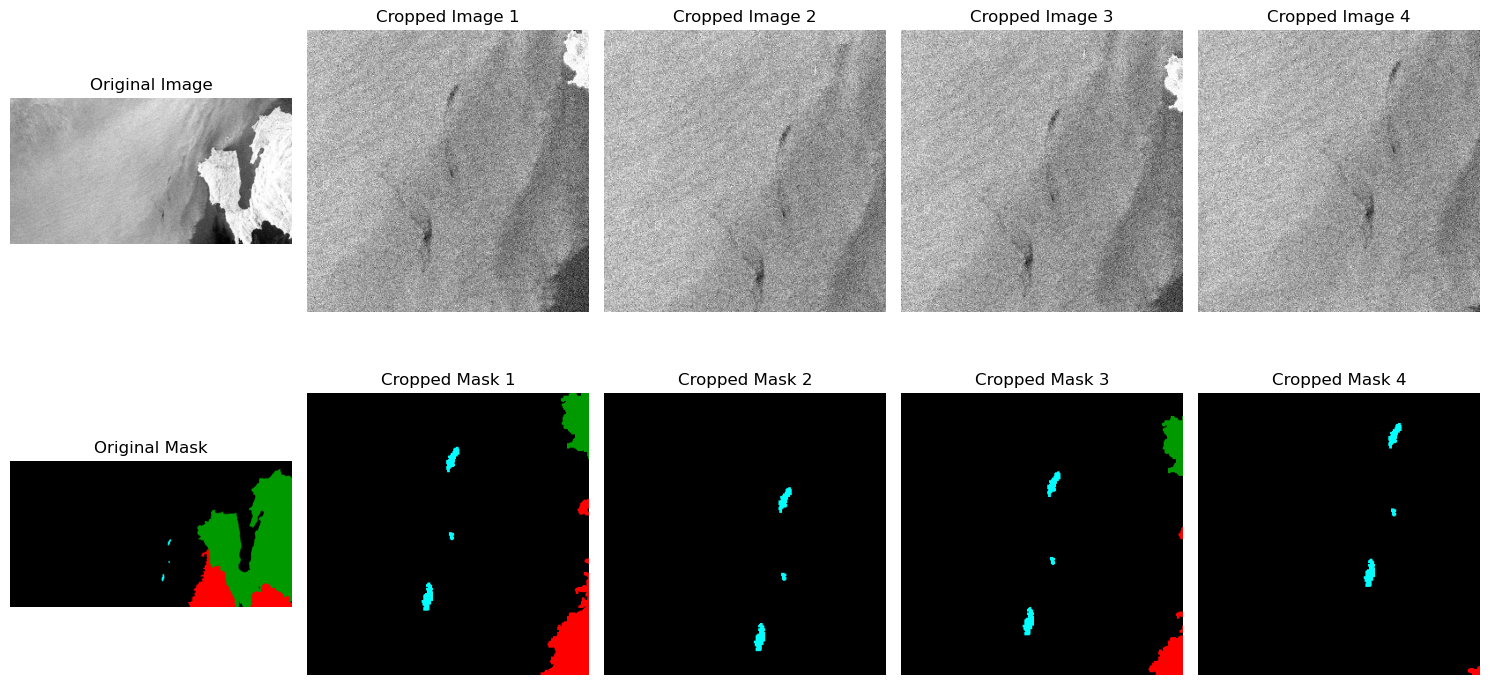

In [95]:
# Instantiate the FocusedCrop class
focused_crop = RandomizedFocusedCrop(crop_size=320, max_shift=80)

# Load a sample image and mask
image_path = "../dataset/train/images/img_0212.jpg" 
mask_path = "../dataset/train/labels_1D/img_0212.png" 

# Open the image and mask
with Image.open(image_path) as img:
    img = img.convert("RGB")  # Ensure it's in RGB format
with Image.open(mask_path) as mask:
    mask = mask.convert("L")  # Ensure it's in grayscale format

# Define the number of random crops
NUM_CROPS = 4

# Apply the focused crop multiple times
cropped_images = []
cropped_masks = []

for _ in range(NUM_CROPS):
    cropped_img, cropped_mask = focused_crop(img, mask)
    cropped_images.append(np.array(cropped_img))
    cropped_masks.append(label_to_rgb(np.array(cropped_mask)))

# =================== RESULTS ===================

original_image_np = np.array(img)
original_mask_np = label_to_rgb(np.array(mask))

# Plot the original and the cropped versions
fig, axs = plt.subplots(2, NUM_CROPS + 1, figsize=(15, 8))

# Plot the original image and mask
axs[0, 0].imshow(original_image_np)
axs[0, 0].set_title("Original Image")
axs[1, 0].imshow(original_mask_np)
axs[1, 0].set_title("Original Mask")

# Plot the cropped images and masks
for i in range(NUM_CROPS):
    axs[0, i + 1].imshow(cropped_images[i])
    axs[0, i + 1].set_title(f"Cropped Image {i + 1}")
    axs[1, i + 1].imshow(cropped_masks[i])
    axs[1, i + 1].set_title(f"Cropped Mask {i + 1}")

# Remove axis ticks
for ax in axs.ravel():
    ax.axis("off")

plt.tight_layout()
plt.show()

# Probabilistic Approach
### Focused Crop with a probability of 50%

In [76]:
from torchvision.transforms import functional as F

class ProbabilisticRandomizedFocusedCrop:
    def __init__(self, crop_transform, crop_size=320, probability=0.5):
        """
        Args:
            crop_transform (callable): The focused crop transformation.
            crop_size (int): The size of the random crop.
            probability (float): The probability of applying the focused crop.
        """
        self.crop_transform = crop_transform
        self.crop_size = crop_size
        self.probability = probability

    def __call__(self, image, mask):
        """
        Applies the focused crop transformation with a given probability if an oil spill is present.
        Otherwise, performs a random crop of the specified size.
        """
        # Convert mask to numpy to check for oil spill
        mask_np = np.array(mask)
        oil_spill_present = np.any(mask_np == 1)

        # Apply focused crop with the given probability if oil spill is present
        if oil_spill_present and random.random() < self.probability:
            cropped_image, cropped_mask = self.crop_transform(image, mask)
            return cropped_image, cropped_mask, True # Boolean only for visualization, TO BE REMOVED!

        # Otherwise, perform a random crop
        width, height = image.size
        top = random.randint(0, max(0, height - self.crop_size))
        left = random.randint(0, max(0, width - self.crop_size))

        # Perform random crop on both image and mask
        cropped_image = F.crop(image, top, left, self.crop_size, self.crop_size)
        cropped_mask = F.crop(mask, top, left, self.crop_size, self.crop_size)

        return cropped_image, cropped_mask, False # Boolean only for visualization, TO BE REMOVED!

## Test

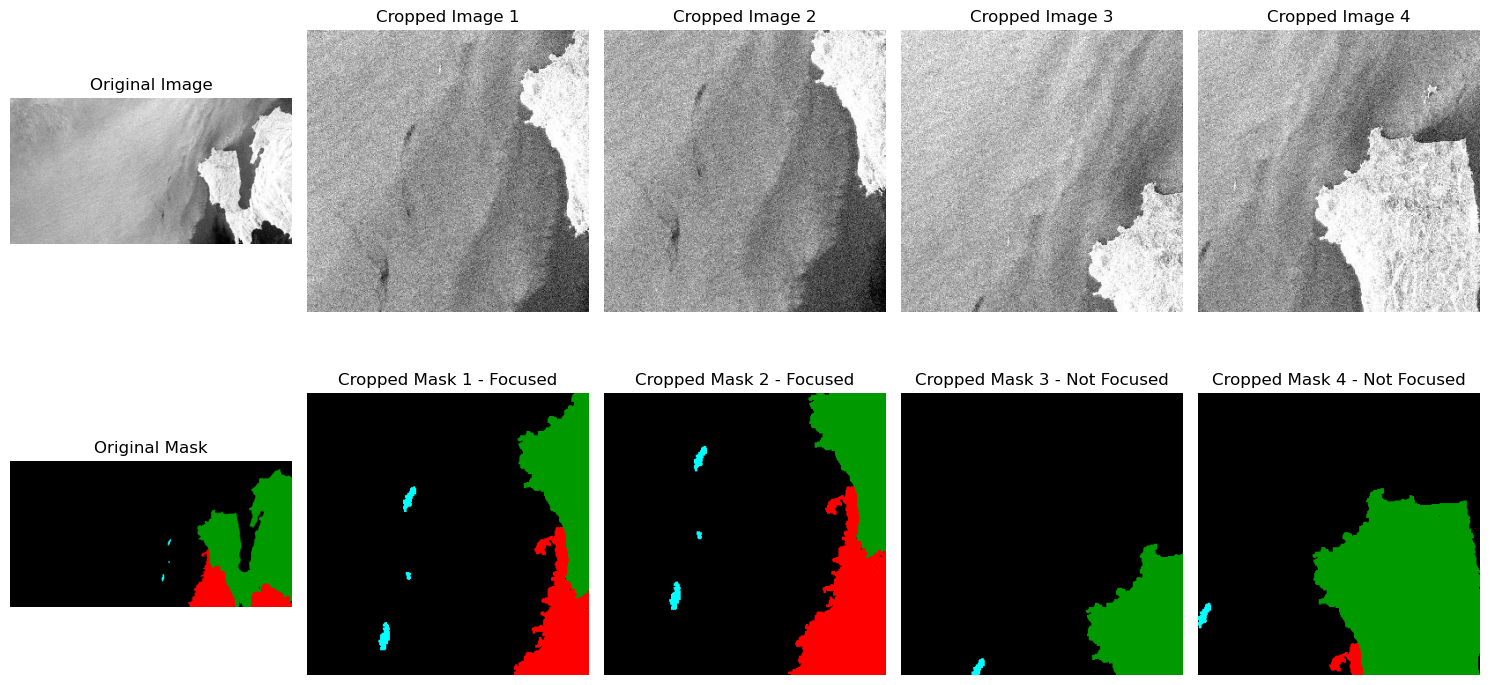

In [101]:
# Instantiate the FocusedCrop class
prob_focused_crop = ProbabilisticRandomizedFocusedCrop(focused_crop, probability=0.5)

# Load a sample image and mask
image_path = "../dataset/train/images/img_0212.jpg" 
mask_path = "../dataset/train/labels_1D/img_0212.png" 

# Open the image and mask
with Image.open(image_path) as img:
    img = img.convert("RGB")  # Ensure it's in RGB format
with Image.open(mask_path) as mask:
    mask = mask.convert("L")  # Ensure it's in grayscale format

# Define the number of random crops
NUM_CROPS = 4

# Apply the focused crop multiple times
prob_cropped_images = []
prob_cropped_masks = []
is_focused_list = []

for _ in range(NUM_CROPS):
    cropped_img, cropped_mask, is_focused = prob_focused_crop(img, mask)
    prob_cropped_images.append(np.array(cropped_img))
    prob_cropped_masks.append(label_to_rgb(np.array(cropped_mask)))
    is_focused_list.append(is_focused)

# =================== RESULTS ===================

original_image_np = np.array(img)
original_mask_np = label_to_rgb(np.array(mask))

# Plot the original and the cropped versions
fig, axs = plt.subplots(2, NUM_CROPS + 1, figsize=(15, 8))

# Plot the original image and mask
axs[0, 0].imshow(original_image_np)
axs[0, 0].set_title("Original Image")
axs[1, 0].imshow(original_mask_np)
axs[1, 0].set_title("Original Mask")

focused_plot = ["Not Focused", "Focused"]
# Plot the cropped images and masks
for i in range(NUM_CROPS):
    axs[0, i + 1].imshow(prob_cropped_images[i])
    axs[0, i + 1].set_title(f"Cropped Image {i + 1}")
    axs[1, i + 1].imshow(prob_cropped_masks[i])
    axs[1, i + 1].set_title(f"Cropped Mask {i + 1} - {focused_plot[is_focused_list[i]]}")

# Remove axis ticks
for ax in axs.ravel():
    ax.axis("off")

plt.tight_layout()
plt.show()